# Introduction to optimization

https://www.youtube.com/watch?v=geFER2oVvvU&t=1870s


The basic components

* The objective function (also called the 'cost' function)

In [1]:
import numpy as np
objective = np.poly1d([1.3, 4.0, 0.6])
print(objective)

     2
1.3 x + 4 x + 0.6


* The "optimizer"

In [2]:
import scipy.optimize as opt
x_ = opt.fmin(objective, [3])
print("solved: x={}".format(x_))

Optimization terminated successfully.
         Current function value: -2.476923
         Iterations: 20
         Function evaluations: 40
solved: x=[-1.53845215]


In [3]:
%matplotlib inline

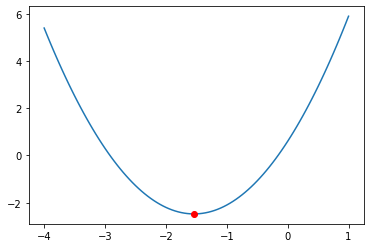

In [4]:
x = np.linspace(-4,1,101)
import matplotlib.pylab as mpl
mpl.plot(x, objective(x))
mpl.plot(x_, objective(x_), 'ro')

Additional components

* "Box" constraints

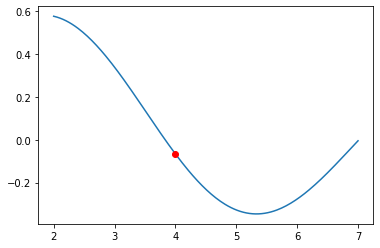

In [5]:
import scipy.special as ss
import scipy.optimize as opt
import numpy as np
import matplotlib.pylab as mpl

x = np.linspace(2, 7, 200)

# 1st order Bessel
j1x = ss.j1(x)
mpl.plot(x, j1x)

# use scipy.optimize's more modern "results object" interface
result = opt.minimize_scalar(ss.j1, method="bounded", bounds=[2, 4])

j1_min = ss.j1(result.x)
mpl.plot(result.x, j1_min,'ro')

* The gradient and/or hessian

In [6]:
import mystic.models as models
print(models.rosen.__doc__)

evaluates an N-dimensional Rosenbrock saddle for a list of coeffs

f(x) = \sum_(i=0)^(N-2) 100*(x_(i+1) - x_(i)^(2))^(2) + (1 - x_(i))^(2)

Inspect with mystic_model_plotter using::
    mystic.models.rosen -b "-3:3:.1, -1:5:.1, 1" -d -x 1

The minimum is f(x)=0.0 at x_i=1.0 for all i


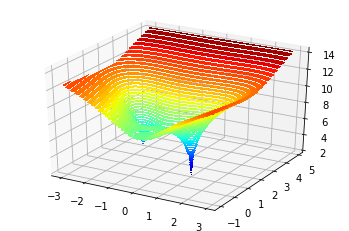

In [7]:
import mystic
mystic.model_plotter(mystic.models.rosen, 
                     kwds='-f -d -x 1 -b "-3:3:.1, -1:5:.1, 1"')

In [8]:
import scipy.optimize as opt
import numpy as np

# initial guess
x0 = [1.3, 1.6, -0.5, -1.8, 0.8]

result = opt.minimize(opt.rosen, x0)
print(result.x)

# number of function evaluations
print(result.nfev)

# again, but this time provide the derivative
result = opt.minimize(opt.rosen, x0, jac=opt.rosen_der)
print(result.x)

# number of function evaluations and derivative evaluations
print(result.nfev, result.njev)
print('')

# however, note for a different x0...
for i in range(5):
    x0 = np.random.randint(-20,20,5)
    result = opt.minimize(opt.rosen, x0, jac=opt.rosen_der)
    print("{} @ {} evals".format(result.x, result.nfev))

[-0.9620501   0.93573761  0.88071026  0.77787182  0.60508459]
378
[-0.96205103  0.9357394   0.88071361  0.77787768  0.60509369]
54 54

[1.         1.00000001 1.00000001 1.00000002 1.00000004] @ 175 evals
[1.         1.         0.99999999 0.99999998 0.99999996] @ 111 evals
[1.         0.99999999 0.99999998 0.99999996 0.99999992] @ 105 evals
[1.         0.99999998 0.99999997 0.99999997 0.99999993] @ 112 evals
[1.         1.         0.99999999 0.99999998 0.99999996] @ 120 evals


* The penalty functions

$\psi(x) = f(x) + k*p(x)$

In [9]:
# http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp
'''
  Maximize: f(x) = 2*x0*x1 + 2*x0 - x0**2 - 2*x1**2
  
  Subject to:    x0**3 - x1 == 0
                         x1 >= 1
'''
import numpy as np

def objective(x, sign=1.0):
    return sign*(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

def derivative(x, sign=1.0):
    dfdx0 = sign*(-2*x[0] + 2*x[1] + 2)
    dfdx1 = sign*(2*x[0] - 4*x[1])
    return np.array([ dfdx0, dfdx1 ])

# unconstrained
result = opt.minimize(objective, [-1.0,1.0], args=(-1.0,),
                      jac=derivative, method='SLSQP', 
                      options={'disp': True})
print("unconstrained: {}".format(result.x))


cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - 1]),
         'jac' : lambda x: np.array([0.0, 1.0])})

# constrained
result = opt.minimize(objective, [-1.0,1.0], args=(-1.0,), jac=derivative,
                      constraints=cons, method='SLSQP', 
                      options={'disp': True})

print("constrained: {}".format(result.x))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.0
            Iterations: 4
            Function evaluations: 5
            Gradient evaluations: 4
unconstrained: [2. 1.]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.0000001831052137
            Iterations: 9
            Function evaluations: 14
            Gradient evaluations: 9
constrained: [1.00000009 1.        ]


Optimizer classifications

* Constrained versus unconstrained (and importantly LP and QP)

In [10]:
# from scipy.optimize.minimize documentation
'''
   **Unconstrained minimization**
    
    Method *Nelder-Mead* uses the Simplex algorithm [1]_, [2]_. This
    algorithm has been successful in many applications but other algorithms
    using the first and/or second derivatives information might be preferred
    for their better performances and robustness in general.
    
    Method *Powell* is a modification of Powell's method [3]_, [4]_ which
    is a conjugate direction method. It performs sequential one-dimensional
    minimizations along each vector of the directions set (`direc` field in
    `options` and `info`), which is updated at each iteration of the main
    minimization loop. The function need not be differentiable, and no
    derivatives are taken.
    
    Method *CG* uses a nonlinear conjugate gradient algorithm by Polak and
    Ribiere, a variant of the Fletcher-Reeves method described in [5]_ pp.
    120-122. Only the first derivatives are used.
    
    Method *BFGS* uses the quasi-Newton method of Broyden, Fletcher,
    Goldfarb, and Shanno (BFGS) [5]_ pp. 136. It uses the first derivatives
    only. BFGS has proven good performance even for non-smooth
    optimizations. This method also returns an approximation of the Hessian
    inverse, stored as `hess_inv` in the OptimizeResult object.
    
    Method *Newton-CG* uses a Newton-CG algorithm [5]_ pp. 168 (also known
    as the truncated Newton method). It uses a CG method to the compute the
    search direction. See also *TNC* method for a box-constrained
    minimization with a similar algorithm.
    
    Method *Anneal* uses simulated annealing, which is a probabilistic
    metaheuristic algorithm for global optimization. It uses no derivative
    information from the function being optimized.
    
    Method *dogleg* uses the dog-leg trust-region algorithm [5]_
    for unconstrained minimization. This algorithm requires the gradient
    and Hessian; furthermore the Hessian is required to be positive definite.
    
    Method *trust-ncg* uses the Newton conjugate gradient trust-region
    algorithm [5]_ for unconstrained minimization. This algorithm requires
    the gradient and either the Hessian or a function that computes the
    product of the Hessian with a given vector.

    **Constrained minimization**
    
    Method *L-BFGS-B* uses the L-BFGS-B algorithm [6]_, [7]_ for bound
    constrained minimization.
    
    Method *TNC* uses a truncated Newton algorithm [5]_, [8]_ to minimize a
    function with variables subject to bounds. This algorithm uses
    gradient information; it is also called Newton Conjugate-Gradient. It
    differs from the *Newton-CG* method described above as it wraps a C
    implementation and allows each variable to be given upper and lower
    bounds.
    
    Method *COBYLA* uses the Constrained Optimization BY Linear
    Approximation (COBYLA) method [9]_, [10]_, [11]_. The algorithm is
    based on linear approximations to the objective function and each
    constraint. The method wraps a FORTRAN implementation of the algorithm.
    
    Method *SLSQP* uses Sequential Least SQuares Programming to minimize a
    function of several variables with any combination of bounds, equality
    and inequality constraints. The method wraps the SLSQP Optimization
    subroutine originally implemented by Dieter Kraft [12]_. Note that the
    wrapper handles infinite values in bounds by converting them into large
    floating values.
'''

"\n   **Unconstrained minimization**\n    \n    Method *Nelder-Mead* uses the Simplex algorithm [1]_, [2]_. This\n    algorithm has been successful in many applications but other algorithms\n    using the first and/or second derivatives information might be preferred\n    for their better performances and robustness in general.\n    \n    Method *Powell* is a modification of Powell's method [3]_, [4]_ which\n    is a conjugate direction method. It performs sequential one-dimensional\n    minimizations along each vector of the directions set (`direc` field in\n    `options` and `info`), which is updated at each iteration of the main\n    minimization loop. The function need not be differentiable, and no\n    derivatives are taken.\n    \n    Method *CG* uses a nonlinear conjugate gradient algorithm by Polak and\n    Ribiere, a variant of the Fletcher-Reeves method described in [5]_ pp.\n    120-122. Only the first derivatives are used.\n    \n    Method *BFGS* uses the quasi-Newton meth

The typical optimization algorithm (local or global) is unconstrained. Constrained algorithms tend strongly to be local, and also often use LP/QP approximations. Hence, most optimization algorithms are good either for quick linear/quadratic approximation under some constraints, or are intended for nonlinear functions without constraints.  Any information about the problem that impacts the potential solution can be seen as constraining information.  Constraining information is typically applied as a penatly, or as a box constraint on an input.  The user is thus typically forced to pick whether they want to apply constraints but treat the problem as a LP/QP approximation, or to ignore the constraining information in exchange for a nonliear solver.

In [11]:
import scipy.optimize as opt

# constrained: linear (i.e. A*x + b)
print(opt.cobyla.fmin_cobyla)
print(opt.linprog)

# constrained: quadratic programming  (i.e. up to x**2)
print(opt.fmin_slsqp)

<function fmin_cobyla at 0x7f95bb1b86a8>
<function linprog at 0x7f95ba04e6a8>
<function fmin_slsqp at 0x7f95bb1b88c8>


In [12]:
# http://cvxopt.org/examples/tutorial/lp.html
'''
minimize:  f = 2*x0 + x1

subject to:
           -x0 + x1 <= 1
            x0 + x1 >= 2
            x1 >= 0
            x0 - 2*x1 <= 4
'''

import cvxopt as cvx
from cvxopt import solvers as cvx_solvers

A = cvx.matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
b = cvx.matrix([ 1.0, -2.0, 0.0, 4.0 ])
cost = cvx.matrix([ 2.0, 1.0 ])
sol = cvx_solvers.lp(cost, A, b)

print(sol['x'])

     pcost       dcost       gap    pres   dres   k/t
 0:  2.6471e+00 -7.0588e-01  2e+01  8e-01  2e+00  1e+00
 1:  3.0726e+00  2.8437e+00  1e+00  1e-01  2e-01  3e-01
 2:  2.4891e+00  2.4808e+00  1e-01  1e-02  2e-02  5e-02
 3:  2.4999e+00  2.4998e+00  1e-03  1e-04  2e-04  5e-04
 4:  2.5000e+00  2.5000e+00  1e-05  1e-06  2e-06  5e-06
 5:  2.5000e+00  2.5000e+00  1e-07  1e-08  2e-08  5e-08
Optimal solution found.
[ 5.00e-01]
[ 1.50e+00]



In [13]:
# http://cvxopt.org/examples/tutorial/qp.html
'''
minimize:  f = 2*x1**2 + x2**2 + x1*x2 + x1 + x2

subject to:
            x1 >= 0
            x2 >= 0
            x1 + x2 == 1
'''

import cvxopt as cvx
from cvxopt import solvers as cvx_solvers

Q = 2*cvx.matrix([ [2, .5], [.5, 1] ])
p = cvx.matrix([1.0, 1.0])
G = cvx.matrix([[-1.0,0.0],[0.0,-1.0]])
h = cvx.matrix([0.0,0.0])
A = cvx.matrix([1.0, 1.0], (1,2))
b = cvx.matrix(1.0)
sol = cvx_solvers.qp(Q, p, G, h, A, b)

print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  3e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  6e-17  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  2e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]



Notice how much nicer it is to see the optimizer "trajectory".  Now, instead of a single number, we have the path the optimizer took in finding the solution. `scipy.optimize` has a version of this, with `options={'retall':True}`, which returns the solver trajectory.

**EXERCISE:** Solve the constrained programming problem by any of the means above.

Minimize: f = -1*x[0] + 4*x[1]

Subject to: <br>
-3*x[0] + 1*x[1] <= 6 <br>
1*x[0] + 2*x[1] <= 4 <br>
x[1] >= -3 <br>

where:  -inf <= x[0] <= inf

* Local versus global

In [14]:
import scipy.optimize as opt

# probabilstic solvers, that use random hopping/mutations
print(opt.differential_evolution)
print(opt.basinhopping)

<function differential_evolution at 0x7f95ba04ed90>
<function basinhopping at 0x7f95ba6ff488>


In [15]:
import scipy.optimize as opt

# bounds instead of an initial guess
bounds = [(-10., 10)]*5

for i in range(10):
    result = opt.differential_evolution(opt.rosen, bounds)
    # result and number of function evaluations
    print(result.x, '@ {} evals'.format(result.nfev))

[-0.96206076  0.93575331  0.88073216  0.77790666  0.60513994] @ 6051 evals
[1. 1. 1. 1. 1.] @ 45306 evals
[1. 1. 1. 1. 1.] @ 42606 evals
[1. 1. 1. 1. 1.] @ 42981 evals
[1. 1. 1. 1. 1.] @ 41931 evals
[1. 1. 1. 1. 1.] @ 41256 evals
[1. 1. 1. 1. 1.] @ 44256 evals
[1. 1. 1. 1. 1.] @ 43806 evals
[1. 1. 1. 1. 1.] @ 44931 evals
[1. 1. 1. 1. 1.] @ 44556 evals


Global optimizers tend to be much slower than local optimizers, and often use randomness to pick points within some box constraints instead of starting with an initial guess. The choice then is between algorithms that are non-deterministic and algorithms that are deterministic but depend very strongly on the selected starting point.

Local optimization algorithms have names like "gradient descent" and "steepest descent", while global optimizations tend to use things like "stocastic" and "genetic" algorithms.

* Not covered: other exotic types

Other important special cases:

* Least-squares fitting

target parameters: [3, 2, 1, 0.7853981633974483]
solved parameters: [3.19665476 1.94924887 1.01507513 0.72439181]
covariance: [0.03968848 0.003841   0.00038771 0.00599505]


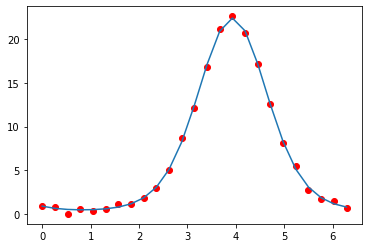

In [16]:
import scipy.optimize as opt
import scipy.stats as stats
import numpy as np

# Define the function to fit.
def function(x, a, b, f, phi):
    result = a * np.exp(-b * np.sin(f * x + phi))
    return result

# Create a noisy data set around the actual parameters
true_params = [3, 2, 1, np.pi/4]
print("target parameters: {}".format(true_params))
x = np.linspace(0, 2*np.pi, 25)
exact = function(x, *true_params)
noisy = exact + 0.3*stats.norm.rvs(size=len(x))

# Use curve_fit to estimate the function parameters from the noisy data.
initial_guess = [1,1,1,1]
estimated_params, err_est = opt.curve_fit(function, x, noisy, 
                                          p0=initial_guess)
print("solved parameters: {}".format(estimated_params))

# err_est is an estimate of the covariance matrix of the estimates
print("covariance: {}".format(err_est.diagonal()))

import matplotlib.pylab as mpl
mpl.plot(x, noisy, 'ro')
mpl.plot(x, function(x, *estimated_params)) 

Least-squares tends to be chosen when the user wants a measure of the covariance, typically as an error estimate.

* Integer programming

Integer programming (IP) or Mixed-integer programming (MIP) requires special optimizers that only select parameter values from the set of integers.  These optimizers are typically used for things like cryptography, or other optimizations over a discrete set of possible solutions.

Typical uses

* Function minimization

* Data fitting

* Root finding

In [37]:
import numpy as np
import scipy.optimize as opt

def system(x,a,b,c):
    x0, x1, x2 = x
    eqs= [
        3 * x0 - np.cos(x1*x2) + a, # == 0
        x0**2 - 81*(x1+0.1)**2 + np.sin(x2) + b, # == 0
        np.exp(-x0*x1) + 20*x2 + c # == 0
    ]
    return eqs


# coefficients
a = -0.5
b = 1.06
c = (10 * np.pi - 3.0) / 3

# initial guess
x0 = [0.1, 0.1, -0.1]

# Solve the system of non-linear equations.
result = opt.root(system, x0, args=(a, b, c))
print("root:", result.x)
print("solution:", result.fun)

root: [ 5.00000000e-01  1.38102142e-13 -5.23598776e-01]
solution: [ 0.00000000e+00 -2.23110419e-12  7.46069873e-14]


* Parameter estimation

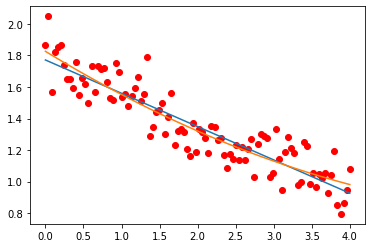

In [38]:
import numpy as np
import scipy.stats as stats

# Create clean data.
x = np.linspace(0, 4.0, 100)
y = 1.5 * np.exp(-0.2 * x) + 0.3

# Add a bit of noise.
noise = 0.1 * stats.norm.rvs(size=100)
noisy_y = y + noise

# Fit noisy data with a linear model.
linear_coef = np.polyfit(x, noisy_y, 1)
linear_poly = np.poly1d(linear_coef)
linear_y = linear_poly(x)

# Fit noisy data with a quadratic model.
quad_coef = np.polyfit(x, noisy_y, 2)
quad_poly = np.poly1d(quad_coef)
quad_y = quad_poly(x)

import matplotlib.pylab as mpl
mpl.plot(x, noisy_y, 'ro')
mpl.plot(x, linear_y)
mpl.plot(x, quad_y)
#mpl.plot(x, y)

Standard diagnostic tools

* Eyeball the plotted solution against the objective

* Run several times and take the best result

* Analyze a log of intermediate results, per iteration

* Rare: look at the covariance matrix

* Issue: how can you really be sure you have the results you were looking for?

**EXERCISE:** Use any of the solvers we've seen thus far to find the minimum of the `zimmermann` function (i.e. use `mystic.models.zimmermann` as the objective).  Use the bounds suggested below, if your choice of solver allows it.

In [39]:
import mystic.models as models
print(models.zimmermann.__doc__)

evaluates a Zimmermann function for a list of coeffs

f(x) = max(f_0(x), p_i(x)), with i = 0,1,2,3

Where:
f_0(x) = 9 - x_0 - x_1
with for x_0 < 0:
p_0(x) = -100 * x_0
and for x_1 < 0:
p_1(x) = -100 * x_1
and for c_2(x) > 16 and c_3(x) > 14:
p_i(x) = 100 * c_i(x), with i = 2,3
c_2(x) = (x_0 - 3)^2 + (x_1 - 2)^2
c_3(x) = x_0 * x_1
Otherwise, p_i(x)=0 for i=0,1,2,3 and c_i(x)=0 for i=2,3.

Inspect with mystic_model_plotter using::
    mystic.models.zimmermann -b "-5:10:.1, -5:10:.1" -d -x 1

The minimum is f(x)=0.0 at x=(7.0,2.0)


**EXERCISE:** Do the same for the `fosc3d` function found at `mystic.models.fosc3d`, using the bounds suggested by the documentation, if your chosen solver accepts bounds or constraints.

More to ponder: what about high-dimenstional and nonlinear constraints?

Let's look at optimization "redesigned" in [mystic](mystic.ipynb)...